**To be able to run a code cell, please click on the Run/Play button located at 
the upper-left corner of a cell.**

![](https://media.giphy.com/media/XyaQAnihoZBU3GmFPl/source.gif)




# Motion Planning for Robots
In daily life, industry, and the scientific exploration processes, the robots, especially the robotic arms, plays an important role in terms of efficiency and accuracy. It is a relatively rigid truth that the forward and inverse kinematics of a robotic arm can be well identified via using explicitly-structured conventions, such as *Denevit-Hartenberg Convention*. However, there are still ambiguous points which are evolving and being developed each day. One of these point is the subject of motion planning. The motion planning task, in summarized form, can be defined as the process of the determination of the route of the robotic arm end effector for a given start point and end point under a constrained environment. In a process similar to this, there are a lot of factor that should be considered and traded-off. Therefore, in literature, there are various methods that distributes importance to different factors.

In this practice session, the aim is to plan the motion of a robotic arm end effector under different obstacle conditions and various spatial properties, such as link lengths and start and end points. In below figure, the representative image that describes the possible physical configuration and the environmental constraint can be investigated.

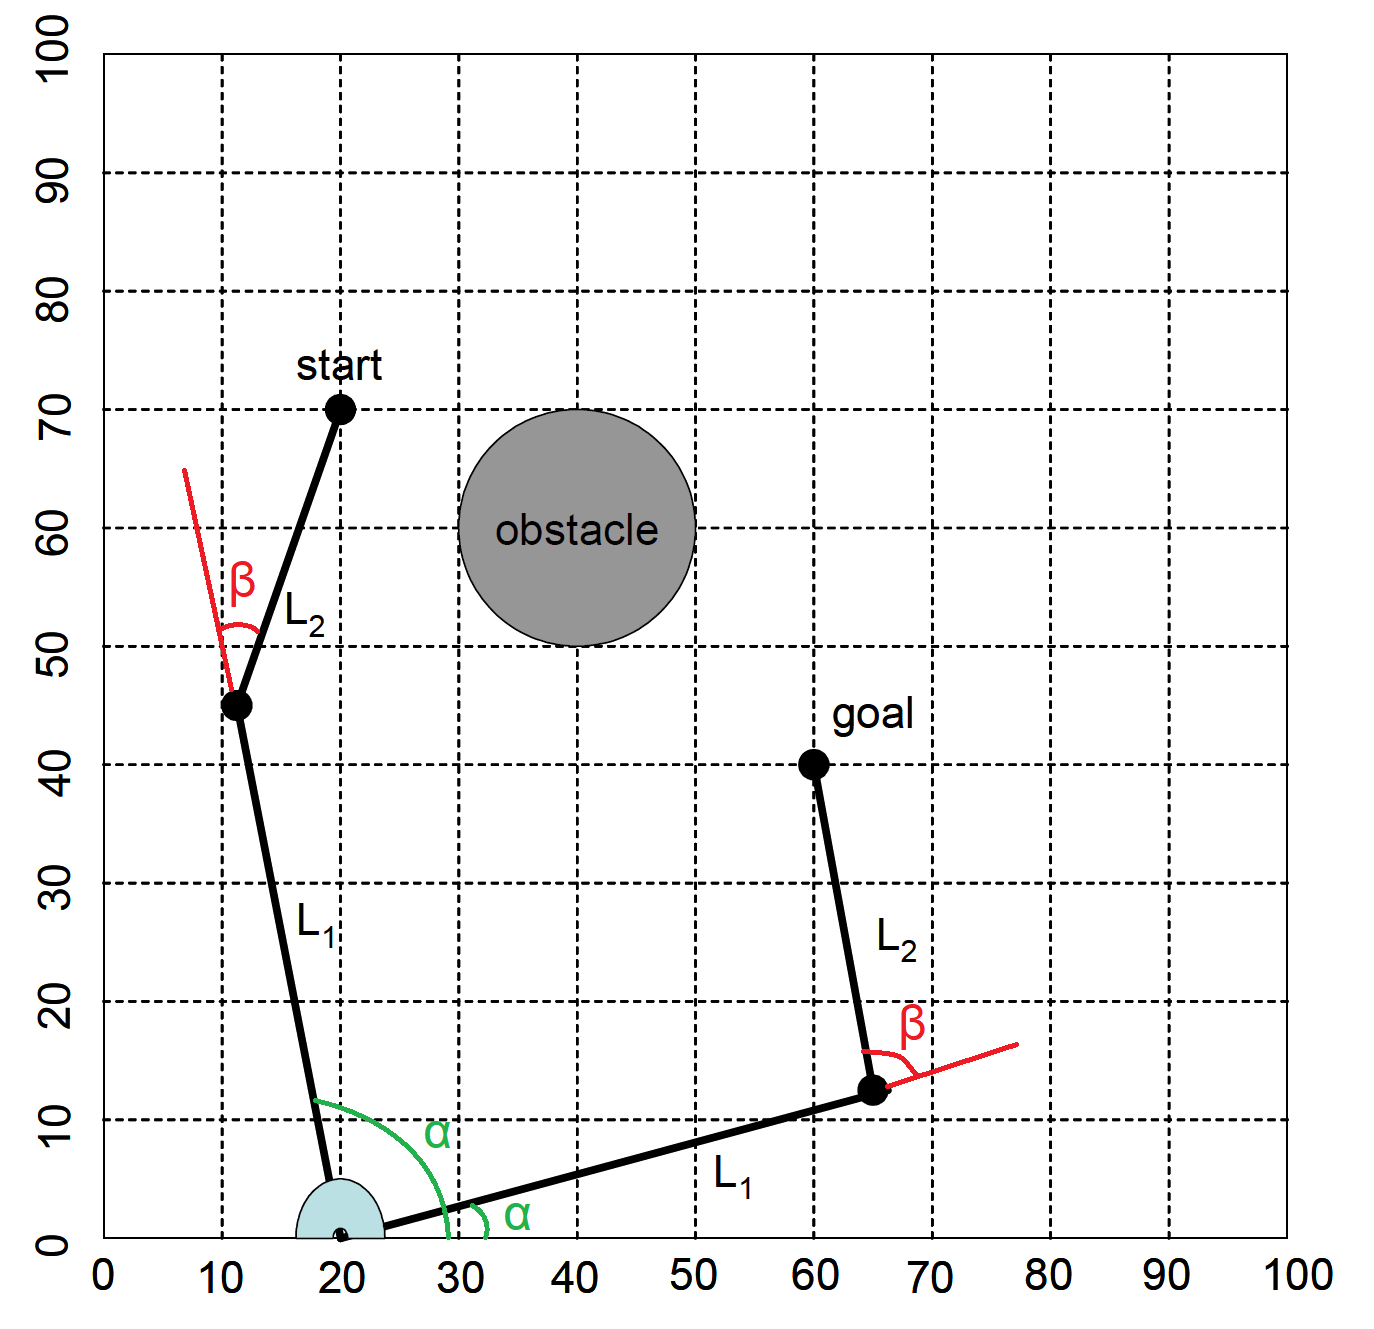


## Update Libraries

In [ ]:
import scipy
import matplotlib
# Check if the SciPy and Matplotlib is up-to-date!
if not (scipy.__version__ == '1.7.1' and matplotlib.__version__ == '3.4.3'):
  !pip install scipy --upgrade
  !pip install matplotlib --upgrade
  exit()

## Import Libraries

In [ ]:
# General array operations  
import numpy as np 
# To find the closest point to a point cloud (in a quick way!)
import scipy
from scipy.spatial import KDTree
# Plotting and animation
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt 
from matplotlib import animation
matplotlib.rc('animation', html='jshtml')
#matplotlib.rcParams['animation.embed_limit'] = 2**128
# Interactive Plotly plots
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# To make interactive I/O
from IPython.display import HTML
from ipywidgets import interact, interact_manual, Layout, IntSlider, Checkbox, Dropdown
# Progress bar
from tqdm.notebook import tqdm 

# Initialization of the array in which the answers will be saved
answers = []

## Configuration Parameters

General parameters to control overall scenerio. You can always change the below parameters and observe the effect. **Don't forget to re-run the cell after modifying it!**

In [ ]:
CONFIG = {"link_1_length": 38,
          "link_2_length": 38,
          "robot_base_x": 20,
          "robot_base_y": 0,
          "obstacle_x": 40,
          "obstacle_y": 60,
          "obstacle_radius": 10,
          "link_discretization_param": 1,
          "angle_discretization_param": 2,
          "rubber_band": 0,
          "start_x": 20,
          "start_y": 70,
          "goal_x": 60,
          "goal_y": 40,
          "start_elbow_up": True,
          "goal_elbow_up": True,
          "attraction_gain": 1,
          "repulsion_gain": 5e3,
          "repulsion_threshold_distance": 20,
          "trajectory_proximity_threshold": 0.1}

## Plotting Functions

These functions are to visualize our computations.

In [ ]:
def draw_collision_map_plotly(collision_map):

  fig = go.Figure()
  trc = go.Scatter(x=collision_map[:, 0], y=collision_map[:, 1], mode='markers')
  fig.add_trace(trc)

  fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    xaxis_range=[0, 180], yaxis_range=[0, 360],
    xaxis_title = r"$\alpha$",
    yaxis_title = r"$\beta$",
    title={
        'text': "Collision Map",
        'x' : 0.5,
        'y' : 1.0,
        'xanchor': 'center',
        'yanchor': 'top'}
)

  return fig, trc

def draw_potential_map_plotly(potential_map, alpha_values, beta_values):

  fig = go.Figure()
  trc = go.Contour(x = alpha_values, y = beta_values, z = potential_map.reshape((alpha_values.shape[0], beta_values.shape[0])).T)
  fig.add_trace(trc)
  
  fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    xaxis_range=[0, 180], yaxis_range=[0, 360],
    xaxis_title = r"$\alpha$",
    yaxis_title = r"$\beta$",
    title={
        'text': "Potential Map",
        'x' : 0.5,
        'y' : 0.9,
        'xanchor': 'center',
        'yanchor': 'top'}
)
  return fig, trc

def draw_potential_map_3d_plotly(potential_map, alpha_values, beta_values):
	

  fig = go.Figure()
  trc = go.Surface(x = alpha_values, y = beta_values, z = potential_map.reshape((alpha_values.shape[0], beta_values.shape[0])).T)
  fig.add_trace(trc)

  fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    xaxis_range=[0, 180], yaxis_range=[0, 360],
    scene = dict(
    xaxis_title = r"$\alpha$",
    yaxis_title = r"$\beta$",
    zaxis_title = "Potential"), 
    title={
        'text': "Potential Map 3D",
        'x' : 0.5,
        'y' : 0.9,
        'xanchor': 'center',
        'yanchor': 'top'}
  )
  return fig, trc

def draw_subplots(trc_collision, trc_potential, trc_potential_3d):
  main_fig = make_subplots(
      rows=1, cols=3,
      subplot_titles=("Collision Map", "Potential Map", "Potential Map 3D"),
      specs=[[{}, {},{'type': 'surface'}]])

  main_fig.add_trace(trc_collision, row=1, col=1)
  main_fig.add_trace(trc_potential, row=1, col=2)
  main_fig.add_trace(trc_potential_3d, row=1, col=3)

  main_fig.update_xaxes(title_text=r"$\alpha$", row=1, col=1, range=[0, 180])
  main_fig.update_xaxes(title_text=r"$\alpha$", row=1, col=2, range=[0, 180])

  main_fig.update_yaxes(title_text=r"$\beta$", row=1, col=1, range=[0, 360])
  main_fig.update_yaxes(title_text=r"$\beta$", row=1, col=2, range=[0, 360])

  main_fig.update_scenes(xaxis = dict(title_text=r"Alpha"),
                        yaxis = dict(title_text=r"Beta"),
                        zaxis = dict(title_text="Potential"))
  return main_fig

def visualize_kinematics(x, y, alpha1, beta1, alpha2=None, beta2=None):
  # Draw the obstacle circle
  
  if alpha2 is None:
    circle = plt.Circle((CONFIG["obstacle_x"], CONFIG["obstacle_y"]), CONFIG["obstacle_radius"], color='r')
    # Draw the links of the robot
    link_1 = plt.Rectangle((CONFIG["robot_base_x"], CONFIG["robot_base_y"]), CONFIG["link_1_length"], 1, alpha1, color = "green")
    link_1_ee_x = CONFIG["link_1_length"] * cosd(alpha1) + CONFIG["robot_base_x"]  # X coordinates of the discretized points on link 1
    link_1_ee_y = CONFIG["link_1_length"] * sind(alpha1) + CONFIG["robot_base_y"]  # Y coordinates of the discretized points on link 1
    link_2 = plt.Rectangle((link_1_ee_x, link_1_ee_y), CONFIG["link_2_length"], 1, alpha1 + beta1)
    
    fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = [10, 10])
    # Set title/label of the cartesian map
    axs.set_title(fr"""Forward Kinematics
    $x$ = {x:.1f}    $y$ = {y:.1f}
    $\alpha$ = {alpha1:.1f}    $\beta$ = {beta1:.1f}""")
    axs.grid()
    axs.set_xlim(0, 100)
    axs.set_ylim(0, 100)
    # Add circle and links to the map
    axs.add_patch(circle)
    axs.add_patch(link_1)
    axs.add_patch(link_2)
  else:
    circle = plt.Circle((CONFIG["obstacle_x"], CONFIG["obstacle_y"]), CONFIG["obstacle_radius"], color='r')
    # Draw the links of the robot
    link_1 = plt.Rectangle((CONFIG["robot_base_x"], CONFIG["robot_base_y"]), CONFIG["link_1_length"], 1,  alpha1, color = "green")
    link_1_ee_x = CONFIG["link_1_length"] * cosd(alpha1) + CONFIG["robot_base_x"]  # X coordinates of the discretized points on link 1
    link_1_ee_y = CONFIG["link_1_length"] * sind(alpha1) + CONFIG["robot_base_y"]  # Y coordinates of the discretized points on link 1
    link_2 = plt.Rectangle((link_1_ee_x, link_1_ee_y), CONFIG["link_2_length"], 1, alpha1 + beta1)
    
    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = [20, 10])
    # Set title/label of the cartesian map elbow up
    axs[0].set_title(fr"""Inverse Kinematics $\uparrow$ Configuration
    $x$ = {x:.1f}    $y$ = {y:.1f}
    $\alpha$ = {alpha1:.1f}    $\beta$ = {beta1:.1f}""")
    axs[0].grid()
    axs[0].set_xlim(0, 100)
    axs[0].set_ylim(0, 100)
    # Add circle and links to the map
    axs[0].add_patch(circle)
    axs[0].add_patch(link_1)
    axs[0].add_patch(link_2)
    
    circle = plt.Circle((CONFIG["obstacle_x"], CONFIG["obstacle_y"]), CONFIG["obstacle_radius"], color='r')
    # Draw the links of the robot
    link_1 = plt.Rectangle((CONFIG["robot_base_x"], CONFIG["robot_base_y"]), CONFIG["link_1_length"], 1,  alpha2, color = "green")
    link_1_ee_x = CONFIG["link_1_length"] * cosd(alpha2) + CONFIG["robot_base_x"]  # X coordinates of the discretized points on link 1
    link_1_ee_y = CONFIG["link_1_length"] * sind(alpha2) + CONFIG["robot_base_y"]  # Y coordinates of the discretized points on link 1
    link_2 = plt.Rectangle((link_1_ee_x, link_1_ee_y), CONFIG["link_2_length"], 1, alpha2 + beta2)

    # Set title/label of the cartesian map elbow down
    axs[1].set_title(fr"""Inverse Kinematics $\downarrow$ Configuration
    $x$ = {x:.1f}    $y$ = {y:.1f}
    $\alpha$ = {alpha2:.1f}    $\beta$ = {beta2:.1f}""")
    axs[1].grid()
    axs[1].set_xlim(0, 100)
    axs[1].set_ylim(0, 100)
    # Add circle and links to the map
    axs[1].add_patch(circle)
    axs[1].add_patch(link_1)
    axs[1].add_patch(link_2)

  return fig

## Mathematical Functions

Below mathematical functions are defined to make things easier.

In [ ]:
def cosd(angle_degree):
  """
  Cosinus calculation for an angle in degree
  """
  return np.cos(np.radians(angle_degree))

def sind(angle_degree):
  """
  Sinus calculation for an angle in degree
  """
  return np.sin(np.radians(angle_degree))

def is_inside_circle(point_x, point_y, center_x, center_y, radius_):
  """
  It checks whether a point (point_x, point_y) is in the interior region of
  a circle whose center coordinates are (center_x, center_y) with a radius of radius_
  """
  return (point_x - center_x) ** 2 + (point_y - center_y) ** 2 <= radius_ ** 2

# Configuration Space Construction
In the motion planning problems, the serial manipulators should not be in collision with the obstacles and its components. During changing joint angles, the operator has to calculate the end-effector's and links position using forward kinematics. After the getting position in the Cartesian space, the operator needs to check the positions from forward kinematics, one by one. However, the configuration space provides the way to represents all of the possible collision configurations as a matrix.


As seen in above figure, the robot has a 2 degree of freedoms, and the environment has a obstacle within the limited workspace. It means that configuration space provides possible configurations without touching the obstacle and without exceeding the boundaries to the path planning algorithm. To be able to construct the configuration space, the forward kinematics of the robot is needed. 



## Forward Kinematics

The robot consists of two links, and from joint angles, it is straightforward to obtain x and y positions using a geometric approach. Note that the location of base of the robot is not at the exact origin. In the following equations for forward kinematics analysis, **$L1$** and **$L2$** represents the links length.

\begin{equation*}
x = x_{\mathrm{base}} + L_1\cos{\alpha} + L_2 \cos{\alpha - \beta}
\end{equation*}

\begin{equation*}
y = y_{\mathrm{base}} + L_1\sin{\alpha} + L_2 \sin{\alpha - \beta}
\end{equation*}



### Code

In [ ]:
def forward_kinematics(theta1, theta2):
  """
  Calculate the corresponding world coordinates of the end effector for
  a given set of joint angles
  """
  position = np.zeros((2,))
  position[0] = CONFIG["link_1_length"] * cosd(theta1) + CONFIG["link_2_length"] * cosd(theta1 + theta2) + CONFIG[
      "robot_base_x"]
  
  position[1] = CONFIG["link_1_length"] * sind(theta1) + CONFIG["link_2_length"] * sind(theta1 + theta2) + CONFIG[
      "robot_base_y"]
  
  return position


## Inverse Kinematics


The Inverse Kinematics can be derived using geometrical approach and algebraic approach. In this study, algebraic approach is selected as a inverse kinematics solver. Initially, the offset from the base of the robot is neglected to obtain purer equations.

\begin{equation*}
x = x_{\mathrm{base}} + L_1\cos{\alpha} + L_2 \cos{\alpha - \beta}
\end{equation*}

\begin{equation*}
y = y_{\mathrm{base}} + L_1\sin{\alpha} + L_2 \sin{\alpha - \beta}
\end{equation*}


If the taking squares and sum of the rows of the equations, the following equation is obtained.


\begin{equation*}
    x^2 +y^2 ={L_1}^2 +{L_2}^{2} +2L_1 L_2 \cos{\beta}
\end{equation*}


\begin{equation*}
    D=\frac{-L_1^2 -L_2^2 +x^2 +y^2}{2L_1 L_2}=\cos{\beta}
\end{equation*}


\begin{equation*}
   \sin{\beta}=\pm \sqrt{1-D^2 }
\end{equation*}


\begin{equation*}
    \beta =-\arctan{\left(\pm \frac{\sqrt{1-D^2}}{D}\right)}
\end{equation*}


From the configuration of the robot, $\beta$ angle should be the opposite direction. Also, there is two solutions for the inverse kinematics, one called elbow up and the another one called elbow down solutions.  For the obtaining $\alpha$ angle, some of the trigonometric transformations are needed, and finally following equations are obtained.

\begin{equation*}
    a=L_2\sin{\beta}
\end{equation*}


\begin{equation*}
    b=L_1 +L_2 \cos{\beta}
\end{equation*}


\begin{equation*}
    c=y
\end{equation*}


\begin{equation*}
    \alpha =\arctan{\frac{c}{\sqrt{a^2 +b^2 -c^2 }}}-\arctan{\frac{a}{b}}
\end{equation*}




### Code

In [ ]:
def inverse_kinematics(x, y, elbow_up = True):
  """
  Calculate the joint angles that produce the given end effector world coordinates,
  with a predefined condiguration (elbow up or elbow down)
  """
  # Calculate the relative position of the world coordinates with respect to base
  # of the robot
  x = x - CONFIG["robot_base_x"]
  y = y - CONFIG["robot_base_y"]

  # Calculate the IK if the point is within reach
  if x ** 2 + y ** 2 <= (CONFIG["link_1_length"] + CONFIG["link_2_length"]) ** 2:
    
    # Intermediate calculations
    c_2 = (x ** 2 + y ** 2 - CONFIG["link_1_length"] ** 2 - CONFIG["link_2_length"] ** 2) / (
            2 * CONFIG["link_1_length"] * CONFIG["link_2_length"])
    
    s_2 = np.sqrt(1 - c_2 ** 2)
    
    theta2 = np.array([np.arctan2(-s_2, c_2), np.arctan2(s_2, c_2)])

    beta = np.arctan2(y, x)
    
    c_psi = (x ** 2 + y ** 2 + CONFIG["link_1_length"] ** 2 - CONFIG["link_2_length"] ** 2) / (
            2 * CONFIG["link_1_length"] * np.sqrt(x ** 2 + y ** 2))
    
    psi = np.arctan2(np.sqrt(1 - c_psi ** 2), c_psi)
    
    theta1 = np.array([beta + psi, beta - psi])

    # Solutions for the elbow up and elbow down situations
    solutions = np.vstack([np.mod(theta1, 2 * np. pi), np.mod(theta2, 2 * np.pi)])
    # Select the solutions based on the configuration preference
    solution = solutions[:, 0] if elbow_up else solutions[:, 1]
    return solution
  else:
    print("Can't find the inverse kinematic solution!")
    raise

In [ ]:
#@markdown
@interact_manual(x=IntSlider(value=20, min=0, max=100, step=1,  description='X-Coordinate', style=dict(description_width='initial'),layout=Layout(width='500px')),
                y=IntSlider(value=76, min=0, max=100, step=1,  description='Y-Coordinate', style=dict(description_width='initial'),layout=Layout(width='500px')),
)
def ik(x, y):
  try:
    alpha1, beta1 = inverse_kinematics(x, y, True)
    alpha2, beta2 = inverse_kinematics(x, y, False)
    visualize_kinematics(x, y, *np.degrees([alpha1, beta1, alpha2, beta2]))
  except:
    print('The robot can not reach the given coordinates ☹')

In [ ]:
#@markdown **Does any part of the robot get out of the workspace boundaries in either configurations when X=20 and Y=20 ?**
Answer = "No" #@param ["","Yes", "No"]
answers.append(Answer)
#@markdown **Does any part of the robot get out of the workspace boundaries in either configurations when X=60 and Y=40 ?**
Answer = "" #@param ["","Yes", "No"]
answers.append(Answer)

##Collision Map Generation
After the deriving forward and inverse kinematics equations, the configuration space is ready to construct. The statements of the construction of the configuration space are listed as follows:
- The end-effector and the links cannot exceed the boundaries: for x direction [0 - 100], for y direction [0 - 100].
- The end-effector and the links cannot collide with the obstacle.


### Code

In [ ]:
def calculate_collision_map():
  """
  It calculates the collision map of the given robot and obstacle configuration.
  Basically, it finds the situations in which there is a collision between
  robot and obstacle.
  """
  print("Generating the collision map...")
  # Collision map initialization
  collision_map = np.empty((0, 2), dtype=np.int32)

  # Constructing a range of alpha and beta values to check if they result in any collision with obstacle
  alpha_values = np.arange(0, 180 + CONFIG["angle_discretization_param"], CONFIG["angle_discretization_param"])
  beta_values = np.arange(0, 360 + CONFIG["angle_discretization_param"], CONFIG["angle_discretization_param"])

  # Construct an array that stores the all possible combinations of the 
  # alpha and beta values
  alpha_grid, beta_grid = np.meshgrid(alpha_values, beta_values)
  map_grid = np.vstack((alpha_grid.flatten(order='F'), beta_grid.flatten(order='F'))).T

  # Discretizing the link of the robot to check whether any portion of them has a contact with the obstacle
  link_1_values = np.arange(0, CONFIG["link_1_length"] + CONFIG["link_discretization_param"], CONFIG["link_discretization_param"])
  link_2_values = np.arange(0, CONFIG["link_2_length"] + CONFIG["link_discretization_param"], CONFIG["link_discretization_param"])

  # For each alpha and beta values

  for (alpha, beta) in tqdm(map_grid):
    # Verbose printing
    #print("Alpha = {}\tBeta = {}".format(alpha, beta), end='\r')

    # Initialization of the checker variable
    is_point_collided = False  # Set this to false for every alpha-beta pair

    # Think of the link 1 as a small version of the original link
    for link_1 in link_1_values:  # Collision check for link 1
      px = link_1 * cosd(alpha) + CONFIG["robot_base_x"]  # X coordinates of the discretized points on link 1
      py = link_1 * sind(alpha) + CONFIG["robot_base_y"]  # Y coordinates of the discretized points on link 1

      # Whether the point is colliding with any of the boundary conditions
      is_point_collided = is_inside_circle(px, py, CONFIG["obstacle_x"], CONFIG["obstacle_y"],
                                            CONFIG["obstacle_radius"] + CONFIG["rubber_band"]) or px < 0 or py < 0 or py > 100 or px > 100 

      if is_point_collided:  
        # If the link 1 violates any of the boundary conditions, terminate the link 1 check
        break

    if is_point_collided:  
      # If link 1 collides with the given alpha-beta pair, then go for the next pair
      collision_map = np.vstack((collision_map, [alpha, beta]))
      continue

    # Think of the link 2 as a small version of the original link
    for link_2 in link_2_values:  # Collision check for link 2

      px = CONFIG["link_1_length"] * cosd(alpha) + link_2 * cosd(
          alpha + beta) + CONFIG["robot_base_x"]  # X coordinates of the discretized points on link 2
      py = CONFIG["link_1_length"] * sind(alpha) + link_2 * sind(
          alpha + beta) + CONFIG["robot_base_y"]  # Y coordinates of the discretized points on link 2

      # Whether the point is colliding with any of the boundary conditions
      is_point_collided = is_inside_circle(px, py, CONFIG["obstacle_x"], CONFIG["obstacle_y"], CONFIG["obstacle_radius"] + CONFIG["rubber_band"]) or (px < 0) or (py < 0) or (py > 100) or (px > 100) 

      if is_point_collided:  
        # If the link 2 violates any of the boundary conditions, terminate the link 2 check
        break

    if is_point_collided:  
      # If link 2 collides with the given alpha-beta pair, then go for the next pair
      collision_map = np.vstack((collision_map, [alpha, beta]))

  # Return the collision map and the discretized alpha and beta values for later use
  return collision_map, alpha_values, beta_values


###Example

**Run the following cell to see configuration space!**

In [ ]:
#@markdown
collision_map, alpha_axis, beta_axis = calculate_collision_map()
fig_collision, trc_collision = draw_collision_map_plotly(collision_map)
fig_collision.show()

As seen in above figure, all of the available configurations were defined into the configuration space. The red dots stands for the obstacles, and the empty region is for the available configurations to the path planning.

# Potential Map Construction


As was discussed in previous section, there are multiple ways of motion planning. In this project, one of the methods used to plan the motion is the *Potential Field Method*. In potential field method, the basic idea is to model the environment such that the obstacles will behave as a repulsive potential and the final configuration will behave as a attractive potential trying to pull the robotic arm end effector to itself. The physical intuition behind this method allows one to construct a force field that will be affected on the end effector of the robotic arm as if it is a point mass that swims in the ocean of the potential field.






## Formulas


### Attractive Field Potential

In attractive field potential, the idea is to model the *final configuration* as a base of the spring, and model the end effector as the free end of the same spring.
Due to this analogy, one can write the attractive potential field as the following:

\begin{equation*}
    P_{attractive} = \frac{1}{2} \zeta \rho_{final} ^ 2 (\mathbf{q}) 
\end{equation*}
where $\mathbf{q}$ represents the instantaneous position of the end effector in the *configuration space*. Then, it can be defined that:

\begin{equation*}
    \rho_{final}(\mathbf{q}) = \| {\mathbf{q} - \mathbf{q_{final}}} \|
\end{equation*}

### Repulsive Potential Field

By constructing a similar physics-based analogy, one can emulate the repulsive field as an potential that imposed on the electron that travels through the different energy states. To be able to materialize the analogy, one can start to write the repulsive potential field as:

\begin{align*}
P_{repulsive}^k = \left\{ \begin{array}{cc} 
                \frac{1}{2} \eta \left( \frac{1}{\rho_k(\mathbf{q})} - \frac{1}{\rho_0}\right)^2 & \hspace{5mm} \rho(\mathbf{q}) < \rho_0 \\
                0 & \hspace{5mm} \rho(\mathbf{q}) > \rho_0 \\
                \end{array} \right.
\end{align*}

\begin{equation*}
    \rho_k(\mathbf{q}) = min \|{\mathbf{q} - \mathbf{q_k}}\|
\end{equation*}

where $\mathbf{q_k}$ represent the individual points that is located in the configuration space point cloud and labeled as obstacle or *unpermitted* point. 




**KDTree** = In computer science, a k-d tree (short for k-dimensional tree) is a space-partitioning data structure for organizing points in a k-dimensional space. k-d trees are a useful data structure for several applications, such as searches involving a multidimensional search key (e.g. range searches and nearest neighbor searches) and creating point clouds. k-d trees are a special case of binary space partitioning trees. 

**We will use the KDTree object of the SciPy library to find the closest point from a point cloud to a query point.**

## Analogy
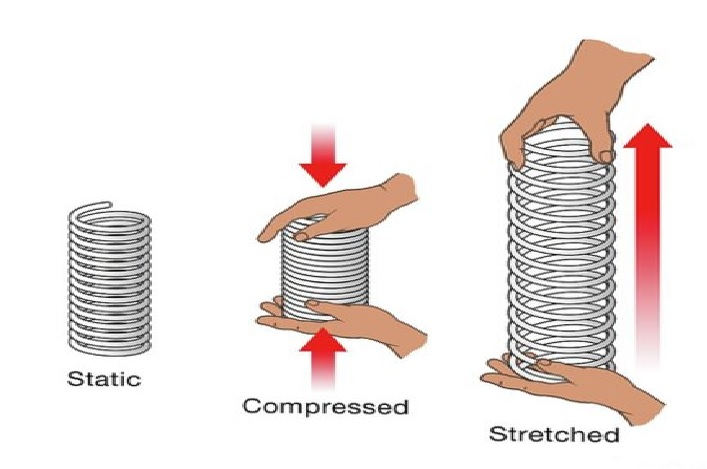

## Code

In [ ]:
def calculate_potential_map(collision_map, alpha_values, beta_values):
  """
  It calculates the potential imposed by the obstacle configuration and the
  goal point.
  """
  # Construct an array that stores the all possible combinations of the 
  # alpha and beta values
  alpha_grid, beta_grid = np.meshgrid(alpha_values, beta_values)
  map_grid = np.vstack((alpha_grid.flatten(order='F'), beta_grid.flatten(order='F'))).T
  
  # Initialize a KDTree object via feeding the subject point cloud, which is the
  # collision map
  kdt = KDTree(collision_map)
  # Then, find the distances which are from the point cloud to query point, which 
  # is whole map of our configuration space.
  # Keep in mind that we can query more than one point at the same time. 
  distances, _ = kdt.query(map_grid, workers=4)
      
  # Calculate the repulsive potential given by the formula
  repulsive_potential = 0.5 * CONFIG['repulsion_gain'] * np.power((1 / distances) - (1 / CONFIG['repulsion_threshold_distance']), 2) 

  # If a distance is larger than a threshold, then its effect is zero
  repulsive_potential[distances > CONFIG['repulsion_threshold_distance']] = 0

  # Calculate the corresponding joint angles for the goal world coordinates
  goal_theta_degree = np.rad2deg(inverse_kinematics(CONFIG["goal_x"], CONFIG["goal_y"], elbow_up=CONFIG['goal_elbow_up']))

  # Calculate the distances between every point and the goal point
  attraction_distances = np.sum((map_grid - goal_theta_degree) ** 2, axis=1)

  # Calculate the attractive potentials as if it is a spring acted on a mass
  attractive_potentials = 0.5 * CONFIG["attraction_gain"] * attraction_distances

  # Calculate the total potentials by summing up repulsive and attractive potential
  potential_map = repulsive_potential + attractive_potentials

  # If there is a infinite value, change it with maximum value
  potential_map[potential_map == np.inf] = potential_map[np.isfinite(potential_map)].max()

  return potential_map

## Example



**Run the following cell to see potential map!**

In [ ]:
potential_map = calculate_potential_map(collision_map, alpha_axis, beta_axis)		
fig_potential, trc_potential = draw_potential_map_plotly(potential_map, alpha_axis, beta_axis)
fig_potential.show()

**Run the below cell to see 3D potential map, and interact with it!**

In [ ]:
fig_potential_3d, trc_potential_3d = draw_potential_map_3d_plotly(potential_map, alpha_axis, beta_axis)
fig_potential_3d.show()

**Run the following cell to see all plots in one figure!**

In [ ]:
draw_subplots(trc_collision, trc_potential, trc_potential_3d)

# Trajectory Generation

## Formulas

In previous sections, the methodology to construct the potential field is discussed, however, the use case that enables one to construct a path to plan the motion is not discussed. Actually, in this point, the virtue of the *potential field* can be acknowledged in two ways. The first way is to use directly the physical fact behind the method. That is, if there exists a potential in the environment, it can be proved that the mass located in this potential will be subjected to a force, which can be quantified as following:

\begin{equation*}
    \mathbf{F} = - \nabla P = 
    \begin{bmatrix} - \frac{\partial P}{\partial x} \\
    \\ - \frac{\partial P}{\partial y} 
    \end{bmatrix}
\end{equation*}

where $P$ represents the sum of the $P_{attractive}$ and $P_{repulsive}$.

The second way to make use of the constructed potential field is to consider this potential field as a objective function and solve an optimization problem under these constraints. That is, if the potential field, *objective function*, is determined beforehand, one can easily incorporate a basic *Gradient Descent Algorithm* on it and construct a route/path.

In this practice session, the harmony of the two aforementioned phenomenons are used. From a force field point of view, one can write the attractive and repulsive force as in the following manner:

\begin{equation*}
    \mathbf{F_{attractive}} = - \zeta \left( \mathbf{q} - \mathbf{q_{final}} \right)
\end{equation*}


\begin{align*}
\mathbf{F_{repulsive}^k} = \left\{ \begin{array}{cc} 
                \frac{1}{2} \eta \left( \frac{1}{\rho_k(\mathbf{q})} - \frac{1}{\rho_0}\right) \frac{1}{\rho_k^2(\mathbf{q})} \nabla \rho_k(\mathbf{q}) & \hspace{5mm} \rho(\mathbf{q}) < \rho_0 \\
                0 & \hspace{5mm} \rho(\mathbf{q}) > \rho_0 \\
                \end{array} \right.
\end{align*}
where
    \begin{equation*}
    \nabla \rho_k(\mathbf{q}) = \frac{\mathbf{q} - \mathbf{q_k}}{\|{\mathbf{q} - \mathbf{q_k}}\|}
\end{equation*}

Finally, for this project, the $\mathbf{F_{repulsive}}$ and $\mathbf{F_{attractive}}$ can be written as:

\begin{equation*}
        \mathbf{F_{attractive}} = - \zeta \left( \mathbf{q} - \mathbf{q_{final}} \right)
\end{equation*}

\begin{equation*}
     \mathbf{F_{repulsive}} =  \max_k(\mathbf{F^k_{repulsive}})
\end{equation*}

In the same way, from a optimization problem point of view, one can write the iterative scheme as the following:

\begin{equation}
    \mathbf{x_{t+1}} = \mathbf{x_t} + \Delta t \frac{\mathbf{F_{total}}}{\|{\mathbf{F_{total}}\|}}
\end{equation}

Now, it should be pointed out that although the physical intuition behind the potential field method is very strong, it has also a few drawbacks. One of these drawbacks is the fact that it can include local minimum points in the overall potential field/objective function. Since, the mission of the iterative scheme is to minimize the potential field such that the end effector of the robotic arm will move from start configuration to final configuration, these undesired local minimum points can halt optimization process and result in unacceptable outcomes.

## Analogy

![](https://upload.wikimedia.org/wikipedia/commons/a/a3/Gradient_descent.gif)

##Code

In [ ]:
def calculate_trajectory_via_search(trajectory_start: np.ndarray, trajectory_goal: np.ndarray, collision_map: np.ndarray):
  """
  It calculates the trajectory via searching the minimum potentials points, exhaustively.
  """
  
  # Initialization of the counter
  idx = 0

  # Local searching step in terms of joint angle
  angle_step = 0.5

  # Initialize the trajectory with the starting point
  trajectory = np.array(trajectory_start,)
  trajectory = np.reshape(trajectory, (1, 2))
  
  # Initialize the checker variable
  is_trajectory_not_finished = True

  while is_trajectory_not_finished:
      
    local_alpha_values = np.arange(trajectory[idx, 0] - angle_step, trajectory[idx, 0] + 2 * angle_step, angle_step)
    local_beta_values = np.arange(trajectory[idx, 1] - angle_step, trajectory[idx, 1] + 2 * angle_step, angle_step)

    # Construct an array that stores the all possible combinations of the 
    # alpha and beta values
    alpha_grid, beta_grid = np.meshgrid(local_alpha_values, local_beta_values)
    local_map_grid = np.vstack((alpha_grid.flatten(order='F'), beta_grid.flatten(order='F'))).T
    
    # Initialize a KDTree object via feeding the subject point cloud, which is the
    # collision map
    kdt = KDTree(collision_map)
    # Then, find the distances which are from the point cloud to query point, which 
    # is whole map of our configuration space.
    # Keep in mind that we can query more than one point at the same time. 
    distances, _ = kdt.query(local_map_grid, workers=-1)

    # Calculate the repulsive potential given by the formula
    local_repulsive_potentials = 0.5 * CONFIG['repulsion_gain'] * np.power((1 / distances) - (1 / CONFIG['repulsion_threshold_distance']), 2) 
    # If a distance is larger than a threshold, then its effect is zero
    local_repulsive_potentials[distances > CONFIG['repulsion_threshold_distance']] = 0 

    # Calculate the distances between every point and the goal point
    local_attraction_distances = np.sum((local_map_grid - trajectory_goal) ** 2, axis=1)
    # Calculate the attractive potentials as if it is a spring acted on a mass
    local_attractive_potentials = 0.5 *  CONFIG["attraction_gain"] * local_attraction_distances;

    # Calculate the total potentials by summing up repulsive and attractive potential
    local_potential_map = local_repulsive_potentials + local_attractive_potentials

    # Calculate the point whose potential is the minimum in the proximity
    # of the local grid
    min_potential_point = local_map_grid[np.argmin(local_potential_map),:].reshape((1,2))
    
    # Add this point to the trajectory
    trajectory = np.vstack((trajectory,min_potential_point))

    # Check whether the desired state is reached
    is_trajectory_not_finished = not (np.linalg.norm(trajectory[-1, :]- trajectory_goal) <= CONFIG["trajectory_proximity_threshold"] or np.array_equal(trajectory[-1,:],trajectory[-2,:]))
    
    # Increase the counter
    idx = idx + 1
  # Return the trajectory
  return trajectory


    
def calculate_trajectory_via_force_propagation(trajectory_start: np.ndarray, trajectory_goal: np.ndarray, collision_map: np.ndarray, step_size = 2):
  """
  It calculates the trajectory via propagating the force, which is calculated by the negative gradient of the potential.
  (Like gradient descent!)
  """
  
  # Initialization of the counter
  idx = 0


  # Initialize the trajectory with the starting point
  trajectory = np.array(trajectory_start,)
  trajectory = np.reshape(trajectory, (1, 2))
  
  # Initialize the checker variable
  is_trajectory_not_finished = True

  while is_trajectory_not_finished:
      
      
    # Initialize a KDTree object via feeding the subject point cloud, which is the
    # collision map
    kdt = KDTree(collision_map)
    # Then, find the distances which are from the point cloud to query point, which 
    # is whole map of our configuration space.
    # Keep in mind that we can query more than one point at the same time. 
    distance, ix_obstacle = kdt.query(trajectory[-1], workers=4)

    # Calculate the repulsive potential given by the formula
    local_repulsive_force = CONFIG['repulsion_gain'] * ((1 / distance) - (1 / CONFIG['repulsion_threshold_distance'])) * (distance ** (-2)) * (2 * (trajectory[-1] - collision_map[ix_obstacle]))   
    # If a distance is larger than a threshold, then its effect is zero
    local_repulsive_force[distance > CONFIG['repulsion_threshold_distance']] = 0 

    # Calculate the attractive force as if it is a spring acted on a mass
    local_attractive_force = -CONFIG["attraction_gain"] * (trajectory[-1] - trajectory_goal);

    # Calculate the total potentials by summing up repulsive and attractive potential
    local_force = local_repulsive_force + local_attractive_force

    trajectory_new = trajectory[-1] + step_size * local_force / np.linalg.norm(local_force)         
    
    # Add this point to the trajectory
    trajectory = np.vstack((trajectory,trajectory_new))

    # Check whether the desired state is reached
    is_trajectory_not_finished = not (np.linalg.norm(trajectory[-1, :]- trajectory_goal) <= CONFIG["trajectory_proximity_threshold"] or np.array_equal(trajectory[-1,:],trajectory[-2,:]) or idx > 1e3)
    
    # Increase the counter
    idx = idx + 1

  # Return the trajectory
  return trajectory

# Animation

In [ ]:
#@markdown
@interact_manual(link_1_length=IntSlider(value=38, min=20, max=50, step=1,  description='Link 1 Length', style=dict(description_width='initial'),layout=Layout(width='500px')),
          link_2_length=IntSlider(value=38, min=20, max=50, step=1,  description='Link 2 Length', style=dict(description_width='initial'),layout=Layout(width='500px')),
          robot_base_x=IntSlider(value=20, min=0, max=100, step=1,  description='X Position of the Robot Base', style=dict(description_width='initial'), layout=Layout(width='500px')),
          robot_base_y=IntSlider(value=0, min=0,max=50, step=1, description='Y Position of the Robot Base', style=dict(description_width='initial'),layout=Layout(width='500px')),
          obstacle_x=IntSlider(value=40, min=0, max=100, step=1,  description='X Position of the Obstacle', style=dict(description_width='initial'),layout=Layout(width='500px')),
          obstacle_y=IntSlider(value=60, min=0, max=100, step=1,  description='Y Position of the Obstacle', style=dict(description_width='initial'),layout=Layout(width='500px')),
          obstacle_radius=IntSlider(value=10, min=5, max=20, step=1,  description='Radius of the Obstacle', style=dict(description_width='initial'),layout=Layout(width='500px')),
          start_x=IntSlider(value=20, min=0, max=100, step=1,  description='X Coordinate of the Starting Point', style=dict(description_width='initial'),layout=Layout(width='500px')),
          start_y=IntSlider(value=70, min=0, max=100, step=1,  description='Y Coordinate of the Starting Point', style=dict(description_width='initial'),layout=Layout(width='500px')),
          goal_x=IntSlider(value=60, min=0, max=100, step=1,  description='X Coordinate of the Goal Point', style=dict(description_width='initial'),layout=Layout(width='500px')),
          goal_y=IntSlider(value=40, min=0, max=100, step=1,  description='Y Coordinate of the Goal Point', style=dict(description_width='initial'),layout=Layout(width='500px')),
          start_elbow_up= Checkbox(False, description='Start With Elbow Up Configuration',style=dict(description_width='initial')),
          goal_elbow_up= Checkbox(False, description='End Up With Elbow Up Configuration',style=dict(description_width='initial')))
def main(**kwords):

  for (key, value) in kwords.items():
    CONFIG[key] = value
  
  # Collision map and potential map generation
  collision_map, alpha_axis, beta_axis = calculate_collision_map()

  # Convert start and goal positions in cartesian coordinate system to configuration space
  start_theta_degree = np.rad2deg(inverse_kinematics(CONFIG["start_x"], CONFIG["start_y"], elbow_up=CONFIG['start_elbow_up']))
  goal_theta_degree = np.rad2deg(inverse_kinematics(CONFIG["goal_x"], CONFIG["goal_y"], elbow_up=CONFIG['goal_elbow_up']))
  print("Calculating trajectory...  ", end="\b")

  # Calculate the trajectory with two different ways!
  trajectory = calculate_trajectory_via_search(start_theta_degree, goal_theta_degree, collision_map)
  print(f'Trajectory calculated with {trajectory.shape[0]} points')
  # Convert the trajectories to Cartesian space
  trajectory_forward = np.empty_like(trajectory)

  for k in range(trajectory.shape[0]):
    trajectory_forward[k] = forward_kinematics(trajectory[k, 0], trajectory[k, 1])

  #! Minimum potential finding is useful when the overall scenario is known beforehand
  #! Force propagation is useful in real-time situations

  # Prepare a 1x2 subplot
  fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = [20, 10])
  plt.close(fig)
  # Initialize the data in the plots
  x_ee, y_ee, alpha, beta = [], [], [], []
  alpha.append(trajectory[0, 0])
  beta.append(trajectory[0, 1])
  x_ee.append(trajectory_forward[0, 0])
  y_ee.append(trajectory_forward[0, 1])

  ####### Collision map plot ###################################################
  # Put "start" - "goal" - "end" points on the collision map
  axs[1].scatter(collision_map[:, 0], collision_map[:, 1], s = 5, c = "red", alpha = 0.5, marker = "s")
  axs[1].scatter(trajectory[0, 0], trajectory[0, 1], marker = r"$start$", s = 1000)
  axs[1].scatter(goal_theta_degree[0], goal_theta_degree[1], marker = r"$goal$", s = 1000)
  if np.linalg.norm(trajectory[-1, :] - [goal_theta_degree[0],goal_theta_degree[1]]) > 2:
    axs[1].scatter(trajectory[-1, 0], trajectory[-1, 1], marker = r"$end$", s = 1000)  
  # Set collision map title
  axs[1].set_title("Collision Map")
  # Put current alpha and beta values on the map
  collision_map_angle_text = axs[1].text(5, 5, fr"""$\alpha$ : {trajectory[0, 0]:.1f} 
  $\beta$ : {trajectory[0, 1]:.1f}""")
  # Put the percentage progress of the trajectory to the map
  collision_map_percentage_text = axs[1].text(90, 180, fr"0%", fontsize = 100, alpha = 0.1, horizontalalignment = 'center', verticalalignment = 'center')
  # Draw the starting point
  collision_map_trajectory, = axs[1].plot(alpha, beta)
  # Set x-axis and y-axis labels/limits
  axs[1].set_xlabel("Alpha")
  axs[1].set_ylabel("Beta")
  axs[1].set_xlim(0, 180)
  axs[1].set_ylim(0, 360)
  ##############################################################################

  ####### Cartesian map plot ###################################################

  # Draw the obstacle circle
  circle = plt.Circle((CONFIG["obstacle_x"], CONFIG["obstacle_y"]), CONFIG["obstacle_radius"], color='r')
  # Draw the links of the robot
  link_1 = plt.Rectangle((CONFIG["robot_base_x"], CONFIG["robot_base_y"]), CONFIG["link_1_length"], 1,  trajectory[0, 0], color = "green")
  link_1_ee_x = CONFIG["link_1_length"] * cosd(trajectory[0, 0]) + CONFIG["robot_base_x"]  # X coordinates of the discretized points on link 1
  link_1_ee_y = CONFIG["link_1_length"] * sind(trajectory[0, 0]) + CONFIG["robot_base_y"]  # Y coordinates of the discretized points on link 1
  link_2 = plt.Rectangle((link_1_ee_x, link_1_ee_y), CONFIG["link_2_length"], 1, trajectory[0, 0] + trajectory[0, 1])

  # Set title/label of the cartesian map
  axs[0].set_title("Cartesian Map")
  axs[0].grid()
  axs[0].set_xlim(0, 100)
  axs[0].set_ylim(0, 100)
  # Add circle and links to the map
  axs[0].add_patch(circle)
  axs[0].add_patch(link_1)
  axs[0].add_patch(link_2)
  # Draw the starting point
  cartesian_map_trajectory, = axs[0].plot(x_ee, y_ee)

  # Put "start" - "goal" - "end" points on the collision map
  axs[0].scatter(trajectory_forward[0, 0], trajectory_forward[0, 1], marker = r"$start$", s = 1000)  
  axs[0].scatter(CONFIG["goal_x"], CONFIG["goal_y"], marker = r"$goal$", s = 1000)
  if np.linalg.norm(trajectory[-1, :] - [goal_theta_degree[0],goal_theta_degree[1]]) > 2:
    axs[0].scatter(trajectory_forward[-1, 0], trajectory_forward[-1, 1], marker = r"$end$", s = 1000)
  # Put the percentage progress of the trajectory to the map
  cartesian_map_percentage_text = axs[0].text(CONFIG["obstacle_x"], CONFIG["obstacle_y"], fr"0%", fontsize = 40, alpha = 0.45, horizontalalignment = 'center', verticalalignment = 'center')
  # Put the current x and y location to the map
  cartesian_map_angle_text = axs[0].text(100 * 5 / 180 , 100 * 5 / 360 , fr"""$x$ : {trajectory_forward[0, 0]:.1f} 
  $y$ : {trajectory_forward[0, 1]:.1f}""")
  ##############################################################################

  ####### General animation function ###########################################

  def animate_robot(n):

    # Add current points to the plots
    alpha.append(trajectory[n, 0])
    beta.append(trajectory[n, 1])
    x_ee.append(trajectory_forward[n, 0])
    y_ee.append(trajectory_forward[n, 1])
    collision_map_trajectory.set_data(alpha, beta)
    cartesian_map_trajectory.set_data(x_ee, y_ee)
    percentage = n / trajectory.shape[0] * 100
    
    # Change link position and angles
    link_1.angle = alpha[-1]
    link_2.angle = beta[-1] + alpha[-1]
    link_1_ee_x = CONFIG["link_1_length"] * cosd(trajectory[n, 0]) + CONFIG["robot_base_x"]  # X coordinates of the discretized points on link 1
    link_1_ee_y = CONFIG["link_1_length"] * sind(trajectory[n, 0]) + CONFIG["robot_base_y"]  # Y coordinates of the discretized points on link 1
    link_2.set_xy((link_1_ee_x, link_1_ee_y))

    # Change current angle in collision map
    collision_map_angle_text.set_text(fr"""$\alpha$ : {trajectory[n, 0]:.1f} 
  $\beta$ : {trajectory[n, 1]:.1f}""")
    # Change percentage in collision map
    collision_map_percentage_text.set_text(fr"{percentage:.1f}%")

    # Change current position in cartesian map
    cartesian_map_angle_text.set_text(fr"""$x$ : {trajectory_forward[n, 0]:.1f} 
  $y$ : {trajectory_forward[n, 1]:.1f}""")
    # Change percentage in cartesian map
    cartesian_map_percentage_text.set_text(fr"{percentage:.1f}%")

    return collision_map_trajectory, cartesian_map_trajectory,
  ##############################################################################

  # Create matplotlib Animation object
  ani = animation.FuncAnimation(fig, animate_robot, frames=np.arange(0, trajectory.shape[0], 5),interval=50,
                    blit=True)  
  #trajectory[0:-1:10].shape[0]
  # Play in the pure HTML
  print("Generating the animation video... (It can take a few minutes!)")
  #return HTML(ani.to_html5_video())
  return ani  


![](https://media.giphy.com/media/l1J3CbFgn5o7DGRuE/giphy.gif)